In [1]:
import numpy as np
import tensorflow as tf
import random
import math
from pathlib import Path
from single_mixed_classes import mixedBrainRegionsRNN
# from mixed_classes_restricted_input import mixedBrainRegionsRNN
from classes import MyBumpBasic

from model_utils import TargetDistractor, get_bump_attractor_weights,create_model_dataset, get_correct_trials#,TargetDistractorMotorPrep
from analysis_utils import get_neuron_selectivity, get_trialwise_mean, split_train_test, find_selective_locations, find_non_selective_locations, zscore_dataset, plot_cross_temporal_decoding, compute_performance_LDA_with_PCAprefit, compute_performance_LDA_with_PCAcomponents 
from matplotlib import pyplot as plt
# plt.style.use('classic')
import itertools
from collections import defaultdict 
from scipy import stats
from itertools import combinations
import sys
import pickle
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Set parameters to load the respective datasets

In [2]:
# # Ranging Parameters
# number_of_trials = 400
max_iters = 200000#10000
model_version_range = np.arange(10) # number of model versions
monkey_session_data = np.load('saved_results/'+'monkey_session_selectivity_trial_data.npy', allow_pickle=True).item()
# set tau and dt parameter ranges
tau_range =[200] # The intrinsic time constant of neural state decay.
dt_percentage = {200:1/4} # The simulation timestep.

input_sigma_range = [0.01]#, 0.05, 0.08, 0.1, 0.15, 0.2] # Noise applied to the input signal
recurrent_noise_range =[0.08]#[0.07]# Independent recurrent noise for each neuronal cell

# Connection percentages between bump and non-bump regions
inner_connect_percen_range = [0.05]
# Connection percentages between 
inter_connect_percen_range = [0]

# Percentage of connections to the downstream output layer
output_projection_percentage = 0.8


bump_percen_range = [0.2]

# folder to save the model data
data_folder_list = ['datasets']
# 
data_folder = 'datasets'
bump_rec_strength = 1


In [4]:
data_folder

'datasets'

# Load Datasets

In [5]:
dataset = {}
dataset_labels = {}
# dataset_weights = {}

dataset_output ={}
dataset_gt={}
dataset_mask={}

In [16]:
model_accuracies_fef = defaultdict(list)

for data_folder in data_folder_list:
    print(data_folder)
    for epoch in ['']:
        for bump_percen in bump_percen_range:
            if bump_percen == 0:
                N_rec1 = bump_population
            elif bump_percen == 1:
                N_rec1 = bump_population
            else:
                N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
                non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
            for tau in tau_range:
                dt = int(tau*dt_percentage[tau])
                for input_sigma in input_sigma_range:
                    for recurrent_noise in recurrent_noise_range: 
                        for inter_connect_percen in inter_connect_percen_range:
                            for inner_connect_percen in inner_connect_percen_range:
                                params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'
                                print(params_values)
                                for model_version in model_version_range:
                                    for region in ['FEF']:
                                        print(region)
                                        for session in np.arange(len(monkey_session_data[region])):
                                            drt = TargetDistractor(N_inputs = inputs, N_outputs=outputs, dt= dt, tau=tau, T=dt*58,
                                                                    cue_start=dt*2, cue_end=dt*8, dis_start=dt*28, dis_end=dt*34, decision_start=dt*54,
                                                                    N_batch = N_batch,
                                                                    sigma=input_sigma)
                                            # name of the model
                                            name1 = name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_' #  Unique name used to determine variable scope for internal use.        
                                            # add the session number in the model name
                                            name = name1+str(model_version)
                                            print("\nIteration: ", model_version, "\nModel name: ", name)

                                            key_name = params_values+name
                                            print(key_name)
                                            data_folder+key_name+'_weights_epoch'+str(epoch)+'.npz'
                                            dataset[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = np.load(data_folder+key_name+'_'+region+str(session)+'_trial_data_epoch'+str(epoch)+'.npy')
                                            dataset_labels[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = np.load(data_folder+key_name+'_'+region+str(session)+'_trial_labels_epoch'+str(epoch)+'.npy')
                                            dataset_output[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = np.load(data_folder+key_name+'_'+region+str(session)+'_mixed-model_output_epoch'+str(epoch)+'.npy')
                                            dataset_gt[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = np.load(data_folder+key_name+'_'+region+str(session)+'_mixed-model_gt_epoch'+str(epoch)+'.npy')
                                            dataset_mask[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)] = np.load(data_folder+key_name+'_'+region+str(session)+'_mixed-model_mask_epoch'+str(epoch)+'.npy')

                                            if region == 'FEF':
                                                model_accuracies_fef[data_folder+params_values+name1+'_'+region+'_accuracies'].append(drt.accuracy_function(dataset_gt[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)],
                                                                                                                                         dataset_output[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)],
                                                                                                                                         dataset_mask[data_folder+key_name+'_'+region+str(session)+'_epoch'+str(epoch)]))


exploring-inner-connection-of-datasets
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/
FEF

Iteration:  0 
Model name:  bump0.2_180Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0

Iteration:  0 
Model name:  bump0.2_180Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0

Iteration:  0 
Model name:  bump0.2_180Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0

Iteration:  0 
Model name:  bump0.2_180Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0

Iteration:  0 
Model name:  bump0.2_180Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_0

Iteration:  0 
Model name:  bump0.2_180Nrec_0
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/


Iteration:  2 
Model name:  bump0.2_180Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_2

Iteration:  2 
Model name:  bump0.2_180Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_2

Iteration:  2 
Model name:  bump0.2_180Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_2

Iteration:  2 
Model name:  bump0.2_180Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_2

Iteration:  2 
Model name:  bump0.2_180Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_2

Iteration:  2 
Model name:  bump0.2_180Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_2

Iteration:  2 
Model name:  bump0.2_180Nrec_2
/stimulus4/dt50/tau200/input-noise0.01/rec-nois


Iteration:  4 
Model name:  bump0.2_180Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_4

Iteration:  4 
Model name:  bump0.2_180Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_4

Iteration:  4 
Model name:  bump0.2_180Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_4

Iteration:  4 
Model name:  bump0.2_180Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_4

Iteration:  4 
Model name:  bump0.2_180Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_4

Iteration:  4 
Model name:  bump0.2_180Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_4

Iteration:  4 
Model name:  bump0.2_180Nrec_4
/stimulus4/dt50/tau200/input-noise0.01/rec-nois


Iteration:  6 
Model name:  bump0.2_180Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_6

Iteration:  6 
Model name:  bump0.2_180Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_6

Iteration:  6 
Model name:  bump0.2_180Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_6

Iteration:  6 
Model name:  bump0.2_180Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_6

Iteration:  6 
Model name:  bump0.2_180Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_6

Iteration:  6 
Model name:  bump0.2_180Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_6

Iteration:  6 
Model name:  bump0.2_180Nrec_6
/stimulus4/dt50/tau200/input-noise0.01/rec-nois


Iteration:  8 
Model name:  bump0.2_180Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_8

Iteration:  8 
Model name:  bump0.2_180Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_8

Iteration:  8 
Model name:  bump0.2_180Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_8

Iteration:  8 
Model name:  bump0.2_180Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_8

Iteration:  8 
Model name:  bump0.2_180Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_8

Iteration:  8 
Model name:  bump0.2_180Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_8

Iteration:  8 
Model name:  bump0.2_180Nrec_8
/stimulus4/dt50/tau200/input-noise0.01/rec-nois

In [17]:
accuracies_fef = []
for k in model_accuracies_fef.keys():
    accuracies_fef.append(model_accuracies_fef[k])

full_space = np.arange(len(bump_percen_range))


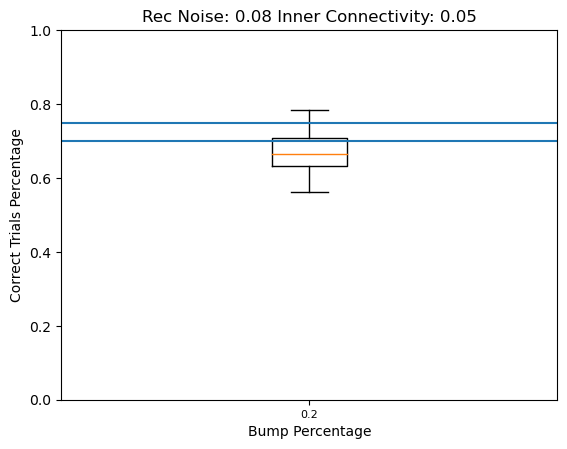

In [18]:
plt.boxplot(accuracies_fef, positions=np.arange(len(bump_percen_range)))
plt.xticks(full_space, bump_percen_range, fontsize=8)
plt.ylim([0, 1])
plt.title("Rec Noise: "+str(recurrent_noise)+" Inner Connectivity: "+str(inner_connect_percen))
plt.xlabel('Bump Percentage')
plt.ylabel('Correct Trials Percentage')
plt.axhline(y=[0.7])
plt.axhline(y=[0.75])

plt.show()

# Correlation analysis

In [371]:
hist_bins = 50
histogram_xrange = [-1, 1]

model_percentages = defaultdict(list)

np.random.seed(10)

all_neurons = defaultdict(list)
all_neurons_labels = defaultdict(list)

significance_level_range = [1e-5]
p_value_threshold = [1e-5]

method = 't-test-locations'

version_pairs_region1 = {}
version_correlations_region1 = {}
version_pvalues_region1 = {}

version_pairs_ = {}#defaultdict(list)
version_correlations_ = {}#defaultdict(list)
version_pvalues_ = {}#defaultdict(list)

model_plot_pairs_bump_low = defaultdict(list)
model_plot_pairs_nonbump_low = defaultdict(list)
model_plot_pairs_corr_mix_low = defaultdict(list)
model_plot_all_high_p_value_pairs = defaultdict(list)

# Subsampling the full histogram plot

exploring-inner-connection-of-datasets
Epoch:  
bump0.2_180Nrec_
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/
FEF
bump0.2_180Nrec_ 0
Session:  0
Session trials:  480
Selective Combinations:  847
Session Selective neuron:  60
Session selectivity:  0.3333333333333333
Session contribution:  0.007575757575757576
Session:  1
Session trials:  480
Selective Combinations:  892
Session Selective neuron:  63
Session selectivity:  0.35
Session contribution:  0.031818181818181815
Session:  2
Session trials:  360
Selective Combinations:  825
Session Selective neuron:  57
Session selectivity:  0.31666666666666665
Session contribution:  0.009595959595959595
Session:  3
Session trials:  360
Selective Combinations:  728
Session Selective neuron:  58
Session selectivity:  0.32222222222222224
Session contribution:  0.01952861952861953
Session:  4
Session trials:  440
Selective Combinations:  1021
Session Selective neuron:  62
Session selectivity:  0.3444444444444

Session Selective neuron:  96
Session selectivity:  0.5333333333333333
Session contribution:  0.03232323232323232
Session:  20
Session trials:  320
Selective Combinations:  2758
Session Selective neuron:  92
Session selectivity:  0.5111111111111111
Session contribution:  0.0038720538720538717
Session:  21
Session trials:  320
Selective Combinations:  2443
Session Selective neuron:  87
Session selectivity:  0.48333333333333334
Session contribution:  0.014646464646464647
Session:  22
Session trials:  500
Selective Combinations:  3509
Session Selective neuron:  100
Session selectivity:  0.5555555555555556
Session contribution:  0.004208754208754209
Session:  23
Session trials:  500
Selective Combinations:  3514
Session Selective neuron:  100
Session selectivity:  0.5555555555555556
Session contribution:  0.03787878787878788
Session:  24
Session trials:  420
Selective Combinations:  2833
Session Selective neuron:  93
Session selectivity:  0.5166666666666667
Session contribution:  0.0156565

Selective Combinations:  569
Session Selective neuron:  52
Session selectivity:  0.28888888888888886
Session contribution:  0.0021885521885521885
Session:  15
Session trials:  200
Selective Combinations:  320
Session Selective neuron:  38
Session selectivity:  0.2111111111111111
Session contribution:  0.012794612794612794
Session:  16
Session trials:  520
Selective Combinations:  1050
Session Selective neuron:  65
Session selectivity:  0.3611111111111111
Session contribution:  0.008207070707070708
Session:  17
Session trials:  520
Selective Combinations:  967
Session Selective neuron:  64
Session selectivity:  0.35555555555555557
Session contribution:  0.00808080808080808
Session:  18
Session trials:  420
Selective Combinations:  682
Session Selective neuron:  56
Session selectivity:  0.3111111111111111
Session contribution:  0.004713804713804714
Session:  19
Session trials:  420
Selective Combinations:  634
Session Selective neuron:  55
Session selectivity:  0.3055555555555556
Session

Session Selective neuron:  69
Session selectivity:  0.38333333333333336
Session contribution:  0.011616161616161618
Session:  9
Session trials:  240
Selective Combinations:  2084
Session Selective neuron:  64
Session selectivity:  0.35555555555555557
Session contribution:  0.0026936026936026937
Session:  10
Session trials:  360
Selective Combinations:  2432
Session Selective neuron:  66
Session selectivity:  0.36666666666666664
Session contribution:  0.0027777777777777775
Session:  11
Session trials:  360
Selective Combinations:  2743
Session Selective neuron:  69
Session selectivity:  0.38333333333333336
Session contribution:  0.02032828282828283
Session:  12
Session trials:  240
Selective Combinations:  2278
Session Selective neuron:  66
Session selectivity:  0.36666666666666664
Session contribution:  0.008333333333333333
Session:  13
Session trials:  240
Selective Combinations:  2177
Session Selective neuron:  64
Session selectivity:  0.35555555555555557
Session contribution:  0.024

Selective Combinations:  2926
Session Selective neuron:  96
Session selectivity:  0.5333333333333333
Session contribution:  0.01616161616161616
Session:  3
Session trials:  360
Selective Combinations:  2757
Session Selective neuron:  90
Session selectivity:  0.5
Session contribution:  0.030303030303030304
Session:  4
Session trials:  440
Selective Combinations:  3157
Session Selective neuron:  94
Session selectivity:  0.5222222222222223
Session contribution:  0.007912457912457913
Session:  5
Session trials:  440


/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Selective Combinations:  2614
Session Selective neuron:  89
Session selectivity:  0.49444444444444446
Session contribution:  0.0412037037037037
Session:  6
Session trials:  540
Selective Combinations:  3012
Session Selective neuron:  89
Session selectivity:  0.49444444444444446
Session contribution:  0.007491582491582492
Session:  7
Session trials:  540
Selective Combinations:  2785
Session Selective neuron:  89
Session selectivity:  0.49444444444444446
Session contribution:  0.044949494949494954
Session:  8
Session trials:  620
Selective Combinations:  3275
Session Selective neuron:  96
Session selectivity:  0.5333333333333333
Session contribution:  0.01616161616161616
Session:  9
Session trials:  240
Selective Combinations:  2424
Session Selective neuron:  87
Session selectivity:  0.48333333333333334
Session contribution:  0.0036616161616161618
Session:  10
Session trials:  360
Selective Combinations:  2543
Session Selective neuron:  88
Session selectivity:  0.4888888888888889
Sessio

Selective Combinations:  5205
Session Selective neuron:  120
Session selectivity:  0.6666666666666666
Session contribution:  0.015151515151515152
Session:  1
Session trials:  480
Selective Combinations:  4542
Session Selective neuron:  120
Session selectivity:  0.6666666666666666
Session contribution:  0.06060606060606061
Session:  2
Session trials:  360
Selective Combinations:  4204
Session Selective neuron:  115
Session selectivity:  0.6388888888888888
Session contribution:  0.01936026936026936
Session:  3
Session trials:  360
Selective Combinations:  3937
Session Selective neuron:  114
Session selectivity:  0.6333333333333333
Session contribution:  0.03838383838383838
Session:  4
Session trials:  440
Selective Combinations:  4569
Session Selective neuron:  117
Session selectivity:  0.65
Session contribution:  0.00984848484848485
Session:  5
Session trials:  440
Selective Combinations:  4779
Session Selective neuron:  119
Session selectivity:  0.6611111111111111
Session contribution:

/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


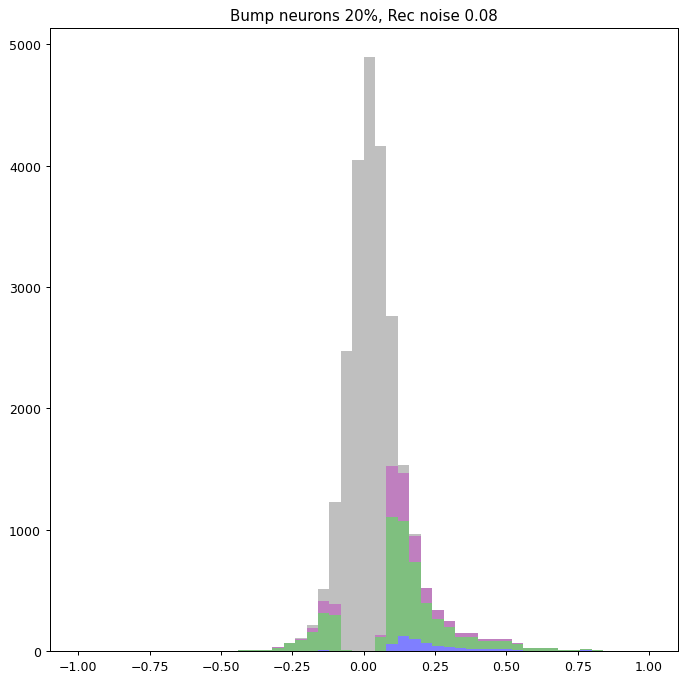

In [135]:
histogram_xrange = [-1,1]
for data_folder in data_folder_list:
    print(data_folder)
    for epoch in ['']:
        print("Epoch: ", epoch)
        for bump_percen in bump_percen_range:
            N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
            non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
#             print('Epoch:', epoch)
            model_name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_'
            print(model_name)
            for significance_level in significance_level_range:
                for tau in tau_range:
                    dt = int(tau*dt_percentage[tau])
                    time_window = [18, 28]
                    delay1_size = 2*(time_window[1]-time_window[0])
                    for input_sigma in input_sigma_range:
                        for recurrent_noise in recurrent_noise_range: 
                            for inter_connect_percen in inter_connect_percen_range:
                                for inner_connect_percen in inner_connect_percen_range:

                                    params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'

                                    print(params_values)

                                    for region in ['FEF']:
                                        print(region)
                                        pairs1 = []
                                        pairs2 = []
                                        pairs3 = []
                                        pair_correlations1 = [] # for bump pair neurons
                                        pair_correlations2 = [] # for non bump pair neurons
                                        pair_correlations3 = [] # for bump-non bump pair neurons
                                        p_values1 = []
                                        p_values2 = []
                                        p_values3 = []

                                        bump_spike_rates=[]
                                        non_bump_spike_rates = []
                                        for model_version in model_version_range:
                                            print(model_name, model_version)
                                            session_contributions = []
                                            for session in np.arange(len(monkey_session_data[region])):
                                                print('Session: ', session)
                                                session_contribution = monkey_session_data[region][session][1]
        #                                         print(session_contribution)
                                                pair_correlations = []
                                                p_values_lists = []
                                                checked_pairs = []
                                                checked_singles = []
                                                checked_singles2 = []

                                                session_selective = []
                                                selective_combinations = []
                                                # Load datasets
                                                data = dataset[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                data_labels = np.argmax(dataset_labels[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)],
                                                                                axis=1)+1
                                                data_output = dataset_output[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                data_gt = dataset_gt[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                data_mask = dataset_mask[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                print("Session trials: ", data.shape[0])
                                                # keep only correct trials
                                                correct_trials = get_correct_trials(data_gt, data_output, data_mask)
                                                data = data[correct_trials,:,:]
                                                data_labels = data_labels[correct_trials]
                                                if np.unique(data_labels).size<=1:
                                                    print("Skipp session, correct data labels only for 1 class!")
                                                    continue

                                                stiched_trial_window_size = 2*(time_window[1]-time_window[0])


                                                zscored_data = zscore_dataset(data[:, time_window[1]-delay1_size:time_window[1], :], data_labels)


                                                selective = get_neuron_selectivity(data[:, time_window[0]:time_window[1], :],
                                                                                   data_labels, method=method,
                                                                                   anova_significance_p=significance_level, ttest_significance_p=significance_level,
                                                                                   prestim_dataset=data[:, 0:2, :])
                                                for key_stim in selective.keys():
                                                    # find all the selective neurons combinations to iterate through
                                                    selective_combinations+=list(combinations(selective[key_stim],2))
                                                print('Selective Combinations: ',len(selective_combinations))
                                                if selective_combinations:
                                                    pair_mapping = []
                                                    for pair in selective_combinations:
                                                        if pair not in checked_pairs:# and np.mod(np.abs(pair[0]-pair[1]),79)<2:
                                                            # find the overlapping locations of the pair cells
                                                            overlaping_locs = [loc for loc in find_selective_locations(pair[0], pair[1], selective)]
                                                            if len(overlaping_locs)!=0:
                                                                # filter locations based on firing rates of the pair neurons
                                                                filtered_locs = defaultdict(list)
                                                                for cell in pair:
                                                                    spike_rate_per_location = []
                                                                    for lc in overlaping_locs:
                                                                        if cell<bump_population:
                                                                                filtered_locs[cell].append(lc)
                                                                        else:
                                                                                filtered_locs[cell].append(lc)

                                                                common_locs = set(filtered_locs[pair[0]]).intersection(filtered_locs[pair[1]])
                                                                if common_locs:
                                                                    all_trials = np.array([])
                                                                    for all_loc in common_locs:
                                                                        all_trials = np.concatenate([all_trials,np.where(data_labels==all_loc)[0]])
                                                                    all_trials = all_trials.astype(int) 
                                                                    stiched_zscored_neuron_trials = np.zeros((2, stiched_trial_window_size*all_trials.shape[0]))
                                                                    for n, neuron in enumerate(pair):
                                                                        stiched_zscored_neuron_trials[n, :] = zscored_data[all_trials, :, neuron].reshape(-1)

                                                                    if bump_percen ==0:
                                                                        pair_mapping.append(2)
                                                                    elif bump_percen ==1:
                                                                        pair_mapping.append(1)
                                                                    else:
                                                                        pair_mapping.append(1 if (pair[0]<bump_population and pair[1]<bump_population) else (2 if (pair[0]>=bump_population and pair[1]>=bump_population) else 3))

                                                                    # find the nan valued trials after zscoring and exclude them from the calculation of correlation 
                                                                    nan_idxs = np.concatenate([np.where(np.isnan(stiched_zscored_neuron_trials[0,:]))[0],
                                                                                    np.where(np.isnan(stiched_zscored_neuron_trials[1,:]))[0]])
                                                                    mask=np.full(stiched_zscored_neuron_trials.shape[1], True)
                                                                    mask[nan_idxs]=False
                                                                    pcis, p_values = stats.pearsonr(stiched_zscored_neuron_trials[0, mask],stiched_zscored_neuron_trials[1, mask])
                                                                    pair_correlations.append(pcis)
                                                                    p_values_lists.append(p_values)
                                                                    checked_pairs.append(pair)
                                                                    for neuron in pair:
                                                                        if neuron not in checked_singles2:
                                                                            checked_singles2.append(neuron)
                                                                            if session in [1,2] and region == 'FEF':
                                                                                all_neurons[data_folder+params_values+model_name+'epoch'+str(epoch)].append(data[all_trials, time_window[1]-delay1_size:time_window[1], neuron])
                                                                                all_neurons_labels[data_folder+params_values+model_name+'epoch'+str(epoch)].append(neuron)

                                                    # keep all pairs and their correlations for each model version to
                                                    # use in temporal decoding based on percentile of correlations histogram
                                                    version_pairs_region1[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)] = checked_pairs
                                                    version_correlations_region1[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)] = pair_correlations
                                                    version_pvalues_region1[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)] = p_values_lists

                                                    # keep only from 1 session and 1 region for each model version
                                                    if session == 0 and region == 'FEF': 
#                                                     if region == 'FEF':
                                                        pairs1.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==1)]+(N_rec1*model_version))
                                                        pairs2.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==2)]+(N_rec1*model_version))
                                                        pairs3.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==3)]+(N_rec1*model_version))

                                                        pair_correlations1.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==1)]))
                                                        pair_correlations2.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==2)]))
                                                        pair_correlations3.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==3)]))
                                                        p_values1.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==1)]))
                                                        p_values2.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==2)]))
                                                        p_values3.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==3)]))
                                                # add selectivity contribution for all sessions
                                                selective_neurons = len(np.unique(np.array(checked_pairs)))
                                                session_selectivity = selective_neurons/data.shape[-1]
                                                session_contributions.append( session_selectivity*session_contribution )
                                                print("Session Selective neuron: ",selective_neurons)
                                                print("Session selectivity: ", session_selectivity)
                                                print("Session contribution: ", session_contributions[-1])

                                            model_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)].append( np.sum(session_contributions) )
                                        flatten_pairs1 = np.array([item for sublist in pairs1 for item in sublist])
                                        flatten_pairs2 = np.array([item for sublist in pairs2 for item in sublist])
                                        flatten_pairs3 = np.array([item for sublist in pairs3 for item in sublist])

                                        flatten_pair_correlations1 = np.array([item for sublist in pair_correlations1 for item in sublist])
                                        flatten_pair_correlations2 = np.array([item for sublist in pair_correlations2 for item in sublist])
                                        flatten_pair_correlations3 = np.array([item for sublist in pair_correlations3 for item in sublist])
                                        flatten_p_values1 = np.array([item for sublist in p_values1 for item in sublist])
                                        flatten_p_values2 = np.array([item for sublist in p_values2 for item in sublist])
                                        flatten_p_values3 = np.array([item for sublist in p_values3 for item in sublist])

                                        pair_corr_bump_low = flatten_pair_correlations1[np.where(flatten_p_values1<p_value_threshold)]
                                        pair_corr_bump_high = flatten_pair_correlations1[np.where(flatten_p_values1>=p_value_threshold)]

                                        pair_corr_nonbump_low = flatten_pair_correlations2[np.where(flatten_p_values2<p_value_threshold)]
                                        pair_corr_nonbump_high = flatten_pair_correlations2[np.where(flatten_p_values2>p_value_threshold)]

                                        pair_corr_mix_low = flatten_pair_correlations3[np.where(flatten_p_values3<p_value_threshold)]
                                        pair_corr_mix_high = flatten_pair_correlations3[np.where(flatten_p_values3>p_value_threshold)]                                                       

                                        bump_spike_rates_flat = np.array([item for sublist in bump_spike_rates for item in sublist])
                                        non_bump_spike_rates_flat = np.array([item for sublist in non_bump_spike_rates for item in sublist])

                                        all_high_p_value_pairs = np.concatenate([pair_corr_bump_high, pair_corr_nonbump_high, pair_corr_mix_high])


                                        print("Pairs: ", pair_corr_bump_low.shape[0]+pair_corr_nonbump_low.shape[0]+pair_corr_mix_low.shape[0]+all_high_p_value_pairs.shape[0])

                                        plt.figure(figsize=(9, 9), dpi=90)
                                        yy,__,__ = plt.hist([pair_corr_bump_low, pair_corr_nonbump_low,
                                                            pair_corr_mix_low, all_high_p_value_pairs], color=['blue','green', 'purple', 'grey'], bins=hist_bins, stacked=True, alpha=0.5, range=[histogram_xrange[0], histogram_xrange[1]],
                                                            label=['Bump Pairs, p-value < '+str(p_value_threshold),
                                                                   'Non-Bump Pairs, p-value < '+str(p_value_threshold),
                                                                   'Mixed Pairs, p-value < '+str(p_value_threshold),
                                                                   'p-value > '+str(p_value_threshold)])
                                        plt.title('Bump neurons '+str(int(bump_percen*100))+'%, Rec noise '+str(recurrent_noise))

                                        plt.show()

                                        model_plot_pairs_bump_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_bump_low
                                        model_plot_pairs_nonbump_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_nonbump_low
                                        model_plot_pairs_corr_mix_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_mix_low
                                        model_plot_all_high_p_value_pairs[data_folder+params_values+model_name+'epoch'+str(epoch)] = all_high_p_value_pairs


Tau:  200
exploring-inner-connection-of-datasets


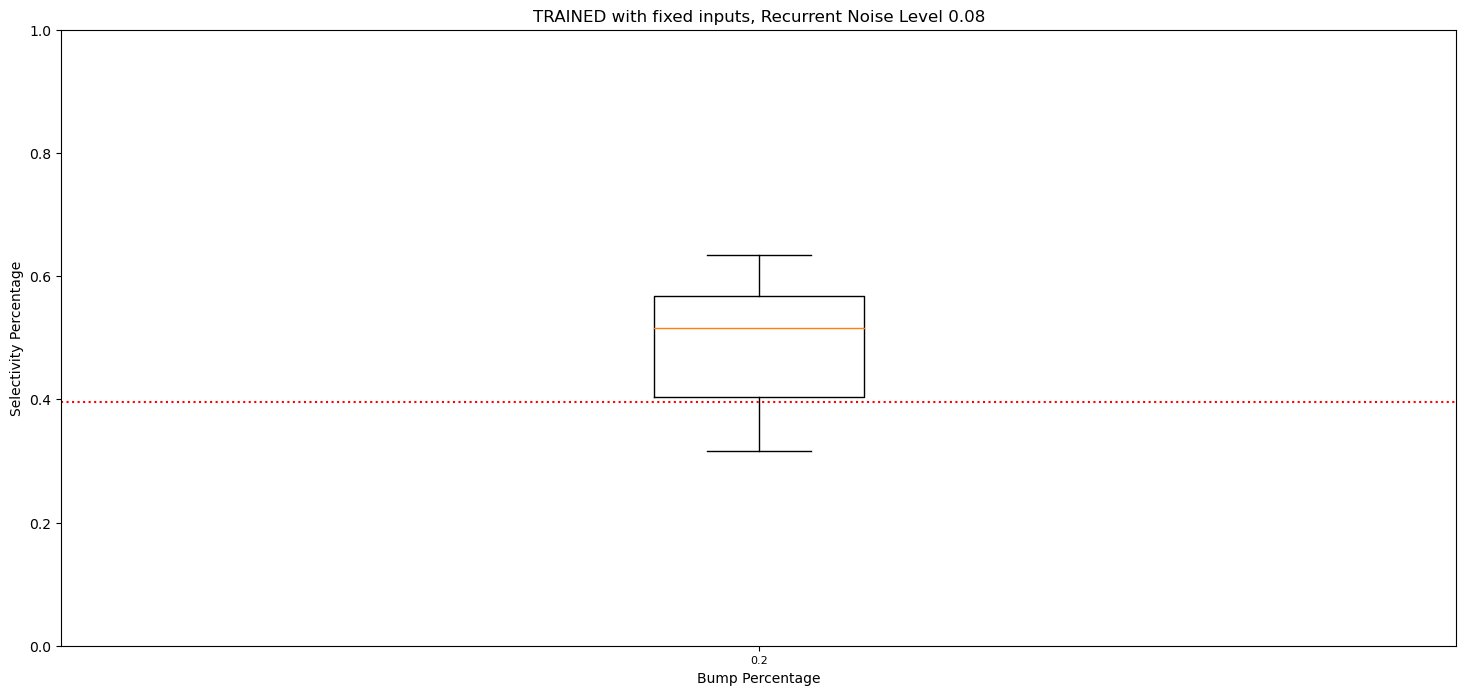

In [136]:
for r, recurrent_noise in enumerate(recurrent_noise_range):
    selective_percentages_fef = []

    x_axis = []
    for tau in tau_range:
        print('Tau: ', tau)
        dt = int(tau*dt_percentage[tau])
        for data_folder in data_folder_list:
            print(data_folder)
            for epoch in ['']:
                for bump_percen in bump_percen_range:
                    if bump_percen == 0:
                        N_rec1 = bump_population#120
                    elif bump_percen == 1:
                        N_rec1 = bump_population
                    else:
                        N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
                        non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
                    model_name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_'
        #             print(model_name)
                    for significance_level in significance_level_range:
                        for input_sigma in input_sigma_range:
                            for inter_connect_percen in inter_connect_percen_range:
                                for inner_connect_percen in inner_connect_percen_range:
                                    params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'
                                    x_axis.append(bump_percen)
                                    selective_percentages_fef.append(model_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)])
#     
    plt.figure(figsize=(18,8))

    full_space = np.arange(len(selective_percentages_fef))

    plt.boxplot(selective_percentages_fef, positions=full_space)
    plt.title('TRAINED with fixed inputs, Recurrent Noise Level '+str(recurrent_noise))

    plt.xticks(full_space, x_axis, fontsize=8)
    plt.ylabel("Selectivity Percentage")
    plt.xlabel("Bump Percentage")

    plt.axhline(y = 61/132, color = 'red', linestyle = 'dotted', label='FEF percentage')

#     plt.legend(loc=4, fontsize=4)
    plt.ylim([0,1])
    plt.show()

# Subsampling each model session

In [481]:
model_significant_neuron_percentages = defaultdict(list)
model_significant_pair_percentages = defaultdict(list)
model_total_significant_non_bump_neuron = defaultdict(list)
model_total_significant_bump_neuron = defaultdict(list)
model_total_non_significant_non_bump_neuron = defaultdict(list)
model_total_non_significant_bump_neuron = defaultdict(list)

model_total_non_selective_neuron = defaultdict(list)

model_total_non_selective_bump_neuron = defaultdict(list)
model_total_non_selective_non_bump_neuron = defaultdict(list)

exploring-inner-connection-of-datasets
Epoch:  
bump0.2_180Nrec_
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/
FEF
bump0.2_180Nrec_ 0
Session:  0
Session trials:  480
Selective Combinations:  15
Session Selective neuron:  8
Session selectivity:  0.3333333333333333
Session contribution:  0.007575757575757576
Session:  1
Session trials:  480
Selective Combinations:  23
Session Selective neuron:  10
Session selectivity:  0.4166666666666667
Session contribution:  0.03787878787878788
Session:  2
Session trials:  360
Selective Combinations:  21
Session Selective neuron:  8
Session selectivity:  0.47058823529411764
Session contribution:  0.014260249554367202
Session:  3
Session trials:  360
Selective Combinations:  3
Session Selective neuron:  3
Session selectivity:  0.17647058823529413
Session contribution:  0.010695187165775402
Session:  4
Session trials:  440
Selective Combinations:  6
Session Selective neuron:  5
Session selectivity:  0.26315789473

Session:  22
Session trials:  500
Selective Combinations:  40
Session Selective neuron:  13
Session selectivity:  0.7222222222222222
Session contribution:  0.005471380471380472
Session:  23
Session trials:  500
Selective Combinations:  30
Session Selective neuron:  9
Session selectivity:  0.5
Session contribution:  0.03409090909090909
Session:  24
Session trials:  420
Selective Combinations:  12
Session Selective neuron:  6
Session selectivity:  0.3157894736842105
Session contribution:  0.009569377990430622
Session:  25
Session trials:  420
Selective Combinations:  37
Session Selective neuron:  12
Session selectivity:  0.631578947368421
Session contribution:  0.043062200956937795
bump0.2_180Nrec_ 2
Session:  0
Session trials:  480
Selective Combinations:  59
Session Selective neuron:  14
Session selectivity:  0.5833333333333334
Session contribution:  0.013257575757575758
Session:  1
Session trials:  480
Selective Combinations:  31
Session Selective neuron:  9
Session selectivity:  0.37

Session:  19
Session trials:  420
Selective Combinations:  4
Session Selective neuron:  5
Session selectivity:  0.38461538461538464
Session contribution:  0.023310023310023312
Session:  20
Session trials:  320
Selective Combinations:  0
Session Selective neuron:  0
Session selectivity:  0.0
Session contribution:  0.0
Session:  21
Session trials:  320
Selective Combinations:  3
Session Selective neuron:  3
Session selectivity:  0.21428571428571427
Session contribution:  0.006493506493506493
Session:  22
Session trials:  500
Selective Combinations:  7
Session Selective neuron:  6
Session selectivity:  0.3333333333333333
Session contribution:  0.002525252525252525
Session:  23
Session trials:  500
Selective Combinations:  10
Session Selective neuron:  7
Session selectivity:  0.3888888888888889
Session contribution:  0.026515151515151512
Session:  24
Session trials:  420
Selective Combinations:  8
Session Selective neuron:  7
Session selectivity:  0.3684210526315789
Session contribution:  

Session:  15
Session trials:  200
Selective Combinations:  10
Session Selective neuron:  6
Session selectivity:  0.6666666666666666
Session contribution:  0.0404040404040404
Session:  16
Session trials:  520
Selective Combinations:  0
Session Selective neuron:  0
Session selectivity:  0.0
Session contribution:  0.0
Session:  17
Session trials:  520
Selective Combinations:  7
Session Selective neuron:  3
Session selectivity:  0.375
Session contribution:  0.008522727272727272
Session:  18
Session trials:  420
Selective Combinations:  1
Session Selective neuron:  2
Session selectivity:  0.15384615384615385
Session contribution:  0.002331002331002331
Session:  19
Session trials:  420
Selective Combinations:  9
Session Selective neuron:  3
Session selectivity:  0.23076923076923078
Session contribution:  0.013986013986013988
Session:  20
Session trials:  320
Selective Combinations:  2
Session Selective neuron:  2
Session selectivity:  0.14285714285714285
Session contribution:  0.001082251082

/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Session:  6
Session trials:  540
Selective Combinations:  25
Session Selective neuron:  9
Session selectivity:  0.47368421052631576
Session contribution:  0.007177033492822967
Session:  7
Session trials:  540
Selective Combinations:  43
Session Selective neuron:  11
Session selectivity:  0.5789473684210527
Session contribution:  0.052631578947368425
Session:  8
Session trials:  620
Selective Combinations:  0
Session Selective neuron:  0
Session selectivity:  0.0
Session contribution:  0.0
Session:  9
Session trials:  240
Selective Combinations:  0
Session Selective neuron:  0
Session selectivity:  0.0
Session contribution:  0.0
Session:  10
Session trials:  360
Selective Combinations:  21
Session Selective neuron:  6
Session selectivity:  0.5454545454545454
Session contribution:  0.004132231404958678
Session:  11
Session trials:  360
Selective Combinations:  4
Session Selective neuron:  5
Session selectivity:  0.45454545454545453
Session contribution:  0.024104683195592287
Session:  12

Session:  3
Session trials:  360
Selective Combinations:  37
Session Selective neuron:  11
Session selectivity:  0.6470588235294118
Session contribution:  0.03921568627450981
Session:  4
Session trials:  440
Selective Combinations:  54
Session Selective neuron:  14
Session selectivity:  0.7368421052631579
Session contribution:  0.011164274322169059
Session:  5
Session trials:  440
Selective Combinations:  38
Session Selective neuron:  12
Session selectivity:  0.631578947368421
Session contribution:  0.05263157894736842
Session:  6
Session trials:  540
Selective Combinations:  75
Session Selective neuron:  15
Session selectivity:  0.7894736842105263
Session contribution:  0.011961722488038277
Session:  7
Session trials:  540
Selective Combinations:  73
Session Selective neuron:  14
Session selectivity:  0.7368421052631579
Session contribution:  0.06698564593301436
Session:  8
Session trials:  620
Selective Combinations:  2
Session Selective neuron:  2
Session selectivity:  0.5
Session c

/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


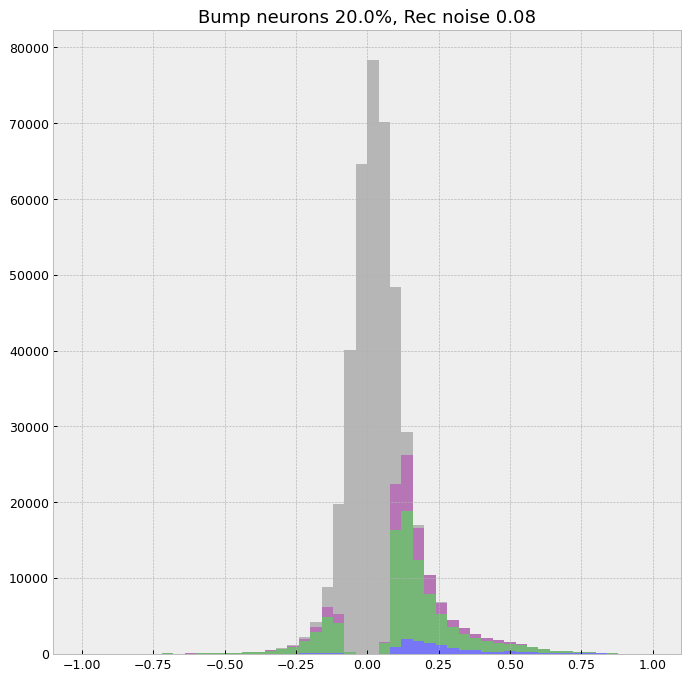

In [482]:
histogram_xrange = [-1,1]
subsampling_iterations = 100
for data_folder in data_folder_list:
    print(data_folder)
    for epoch in ['']:
        print("Epoch: ", epoch)
        for bump_percen in bump_percen_range:
            N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
            non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
#             print('Epoch:', epoch)
            model_name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_'
            print(model_name)
            for significance_level in significance_level_range:
                for tau in tau_range:
                    dt = int(tau*dt_percentage[tau])
                    time_window = [18, 28]
                    delay1_size = 2*(time_window[1]-time_window[0])
                    for input_sigma in input_sigma_range:
                        for recurrent_noise in recurrent_noise_range: 
                            for inter_connect_percen in inter_connect_percen_range:
                                for inner_connect_percen in inner_connect_percen_range:
                                    params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'
                                    print(params_values)
                                    for region in ['FEF']:
                                        print(region)
                                        pairs1 = []
                                        pairs2 = []
                                        pairs3 = []
                                        pair_correlations1 = [] # for bump pair neurons
                                        pair_correlations2 = [] # for non bump pair neurons
                                        pair_correlations3 = [] # for bump-non bump pair neurons
                                        p_values1 = []
                                        p_values2 = []
                                        p_values3 = []

                                        bump_spike_rates=[]
                                        non_bump_spike_rates = []
                                        for model_version in model_version_range:
                                            print(model_name, model_version)
                                            session_contributions = []
                                            session_significant_neurons = []
                                            session_number_of_neurons = []

                                            session_significant_pairs = []
                                            session_number_of_pairs = []
                                            total_significant_non_bump_neurons = 0
                                            total_significant_bump_neurons = 0
                                            total_non_significant_non_bump_neurons = 0
                                            total_non_significant_bump_neurons = 0
                                            total_non_selective_neurons = 0
                                            
                                            total_non_selective_bump_neurons = 0
                                            total_non_selective_non_bump_neurons = 0
                                            for session in np.arange(len(monkey_session_data[region])):
                                                print('Session: ', session)
                                                session_contribution = monkey_session_data[region][session][1]
                                                session_neurons = monkey_session_data[region][session][2]
        #                                         print(session_contribution)
                                                for subsampling_iteration in np.arange(subsampling_iterations):
                                                    pair_correlations = []
                                                    p_values_lists = []
                                                    checked_pairs = []
                                                    checked_singles = []
                                                    checked_singles2 = []

                                                    session_selective = []
                                                    selective_combinations = []
                                                    # Load datasets
                                                    data = dataset[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    data_labels = np.argmax(dataset_labels[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)],
                                                                                    axis=1)+1
                                                    data_output = dataset_output[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    data_gt = dataset_gt[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    data_mask = dataset_mask[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    if subsampling_iteration == 0:
                                                        print("Session trials: ", data.shape[0])
                                                    # keep only correct trials
                                                    correct_trials = get_correct_trials(data_gt, data_output, data_mask)

                                                    data = data[correct_trials,:,:]
                                                    # subsample the model neuron population to match the monkey data session
                                                    subsampled_indices = np.random.choice(data.shape[-1], session_neurons, replace=False)
                                                    data = data[:,:,subsampled_indices]
                                                    data_labels = data_labels[correct_trials]
                                                    if np.unique(data_labels).size<=1:
                                                        print("Skipp session, correct data labels only for 1 class!")
                                                        continue

                                                    stiched_trial_window_size = 2*(time_window[1]-time_window[0])


                                                    zscored_data = zscore_dataset(data[:, time_window[1]-delay1_size:time_window[1], :], data_labels)


                                                    selective = get_neuron_selectivity(data[:, time_window[0]:time_window[1], :],
                                                                                       data_labels, method=method,
                                                                                       anova_significance_p=significance_level, ttest_significance_p=significance_level,
                                                                                       prestim_dataset=data[:, 0:2, :])
                                                    for key_stim in selective.keys():
                                                        # find all the selective neurons combinations to iterate through
                                                        selective_combinations+=list(combinations(selective[key_stim],2))
                                                    if subsampling_iteration == 0:
                                                        print('Selective Combinations: ',len(selective_combinations))
                                                    if selective_combinations:
                                                        pair_mapping = []
                                                        for pair in selective_combinations:
                                                            if pair not in checked_pairs:# and np.mod(np.abs(pair[0]-pair[1]),79)<2:
                                                                # find the overlapping locations of the pair cells
                                                                overlaping_locs = [loc for loc in find_selective_locations(pair[0], pair[1], selective)]
                                                                if len(overlaping_locs)!=0:
                                                                    # filter locations based on firing rates of the pair neurons
                                                                    filtered_locs = defaultdict(list)
                                                                    for cell in pair:
                                                                        spike_rate_per_location = []
                                                                        for lc in overlaping_locs:
                                                                            if cell<bump_population:
                                                                                    filtered_locs[cell].append(lc)
                                                                            else:
                                                                                    filtered_locs[cell].append(lc)

                                                                    common_locs = set(filtered_locs[pair[0]]).intersection(filtered_locs[pair[1]])
                                                                    if common_locs:
                                                                        all_trials = np.array([])
                                                                        for all_loc in common_locs:
                                                                            all_trials = np.concatenate([all_trials,np.where(data_labels==all_loc)[0]])
                                                                        all_trials = all_trials.astype(int) 
                                                                        stiched_zscored_neuron_trials = np.zeros((2, stiched_trial_window_size*all_trials.shape[0]))
                                                                        for n, neuron in enumerate(pair):
                                                                            stiched_zscored_neuron_trials[n, :] = zscored_data[all_trials, :, neuron].reshape(-1)

                                                                        if bump_percen ==0:
                                                                            pair_mapping.append(2)
                                                                        elif bump_percen ==1:
                                                                            pair_mapping.append(1)
                                                                        else:
#                                                                             pair_mapping.append(1 if (pair[0]<bump_population and pair[1]<bump_population) else (2 if (pair[0]>=bump_population and pair[1]>=bump_population) else 3))
                                                                            pair_mapping.append(1 if (subsampled_indices[pair[0]]<bump_population and subsampled_indices[pair[1]]<bump_population) else (2 if (subsampled_indices[pair[0]]>=bump_population and subsampled_indices[pair[1]]>=bump_population) else 3))

                                                                        # find the nan valued trials after zscoring and exclude them from the calculation of correlation 
                                                                        nan_idxs = np.concatenate([np.where(np.isnan(stiched_zscored_neuron_trials[0,:]))[0],
                                                                                        np.where(np.isnan(stiched_zscored_neuron_trials[1,:]))[0]])
                                                                        mask=np.full(stiched_zscored_neuron_trials.shape[1], True)
                                                                        mask[nan_idxs]=False
                                                                        pcis, p_values = stats.pearsonr(stiched_zscored_neuron_trials[0, mask],stiched_zscored_neuron_trials[1, mask])
                                                                        pair_correlations.append(pcis)
                                                                        p_values_lists.append(p_values)
                                                                        checked_pairs.append(pair)

                                                        # keep all pairs and their correlations for each model version to
                                                        # use in temporal decoding based on percentile of correlations histogram
                                                        version_pairs_[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)+'_subsample'+str(subsampling_iteration)] = [(subsampled_indices[pair_[0]], subsampled_indices[pair_[1]]) for pair_ in checked_pairs]
                                                        version_correlations_[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)+'_subsample'+str(subsampling_iteration)] = pair_correlations
                                                        version_pvalues_[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)+'_subsample'+str(subsampling_iteration)] = p_values_lists

                                                        # keep only from 1 session and 1 region for each model version 
                                                        if region == 'FEF':
                                                            pairs1.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==1)]+(N_rec1*len(model_version_range)*len(monkey_session_data[region])))#(N_rec1*model_version))
                                                            pairs2.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==2)]+(N_rec1*len(model_version_range)*len(monkey_session_data[region])))
                                                            pairs3.append(np.array(checked_pairs)[np.where(np.array(pair_mapping)==3)]+(N_rec1*len(model_version_range)*len(monkey_session_data[region])))

                                                            pair_correlations1.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==1)]))
                                                            pair_correlations2.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==2)]))
                                                            pair_correlations3.append(list(np.array(pair_correlations)[np.where(np.array(pair_mapping)==3)]))
                                                            p_values1.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==1)]))
                                                            p_values2.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==2)]))
                                                            p_values3.append(list(np.array(p_values_lists)[np.where(np.array(pair_mapping)==3)]))

                                                    # calculate significant neurons and pairs
                                                    significant_pairs = np.array(checked_pairs)[np.where(np.array(p_values_lists)<significance_level)[0]]
                                                    non_significant_pairs = np.array(checked_pairs)[np.where(np.array(p_values_lists)>=significance_level)[0]]

                                                    significant_neurons = np.unique(significant_pairs)
                                                    non_significant_neurons = np.unique(non_significant_pairs)

                                                    significant_neurons_number =  len(significant_neurons)
                                                    non_significant_neurons_number = len(non_significant_neurons)
                                                    
                                                    significant_pairs_number = len(significant_pairs)
                                                    non_significant_pairs_number = len(non_significant_pairs)
                                                    
                                                    original_neuron_indices_significant = np.array([subsampled_indices[n_] for n_ in significant_neurons])
                                                    total_significant_non_bump_neurons += np.where(original_neuron_indices_significant>=bump_population)[0].shape[0]
                                                    total_significant_bump_neurons += np.where(original_neuron_indices_significant<bump_population)[0].shape[0]
                                                    
                                                    original_neuron_indices_non_significant = np.array([subsampled_indices[n_] for n_ in non_significant_neurons if subsampled_indices[n_] not in original_neuron_indices_significant])
                                                    total_non_significant_non_bump_neurons += np.where(original_neuron_indices_non_significant>=bump_population)[0].shape[0]
                                                    total_non_significant_bump_neurons += np.where(original_neuron_indices_non_significant<bump_population)[0].shape[0]
                                                    
                                                    # check non selective neurons
                                                    total_non_selective_neurons += subsampled_indices.shape[0]- np.unique(checked_pairs).shape[0]
                                                    
                                                    original_neuron_indices_selective = np.array([subsampled_indices[n_] for n_ in np.unique(checked_pairs)])
                                                    original_neuron_indices_non_selective = np.array([neuron_ for neuron_ in subsampled_indices if neuron_ not in original_neuron_indices_selective])
                                                    total_non_selective_bump_neurons += np.where(original_neuron_indices_non_selective<bump_population)[0].shape[0]
                                                    total_non_selective_non_bump_neurons += np.where(original_neuron_indices_non_selective>=bump_population)[0].shape[0]
                                                    
                                                    session_significant_neurons.append(significant_neurons_number)
                                                    session_number_of_neurons.append(len(np.unique(checked_pairs)))
                                                    session_significant_pairs.append(significant_pairs_number)
                                                    session_number_of_pairs.append(len(checked_pairs))
                                                    
                                                    if subsampling_iteration == 0:
                                                        # add selectivity contribution for all sessions
                                                        selective_neurons = len(np.unique(np.array(checked_pairs)))
                                                        session_selectivity = selective_neurons/data.shape[-1]
                                                        session_contributions.append( session_selectivity*session_contribution )
                                                        print("Session Selective neuron: ",selective_neurons)
                                                        print("Session selectivity: ", session_selectivity)
                                                        print("Session contribution: ", session_contributions[-1])
                                                
                                            model_significant_neuron_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)].append(np.sum(session_significant_neurons)/np.sum(session_number_of_neurons))
                                            model_significant_pair_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)].append(np.sum(session_significant_pairs)/np.sum(session_number_of_pairs))
                                            model_total_significant_non_bump_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_significant_non_bump_neurons)
                                            model_total_significant_bump_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_significant_bump_neurons)
                                            model_total_non_significant_non_bump_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_non_significant_non_bump_neurons)
                                            model_total_non_significant_bump_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_non_significant_bump_neurons)
                                            
                                            model_total_non_selective_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_non_selective_neurons)
                                            model_total_non_selective_bump_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_non_selective_bump_neurons)
                                            model_total_non_selective_non_bump_neuron[data_folder+params_values+model_name+'epoch'+str(epoch)].append(total_non_selective_non_bump_neurons)

                                        flatten_pairs1 = np.array([item for sublist in pairs1 for item in sublist])
                                        flatten_pairs2 = np.array([item for sublist in pairs2 for item in sublist])
                                        flatten_pairs3 = np.array([item for sublist in pairs3 for item in sublist])

                                        flatten_pair_correlations1 = np.array([item for sublist in pair_correlations1 for item in sublist])
                                        flatten_pair_correlations2 = np.array([item for sublist in pair_correlations2 for item in sublist])
                                        flatten_pair_correlations3 = np.array([item for sublist in pair_correlations3 for item in sublist])
                                        flatten_p_values1 = np.array([item for sublist in p_values1 for item in sublist])
                                        flatten_p_values2 = np.array([item for sublist in p_values2 for item in sublist])
                                        flatten_p_values3 = np.array([item for sublist in p_values3 for item in sublist])

                                        pair_corr_bump_low = flatten_pair_correlations1[np.where(flatten_p_values1<p_value_threshold)]
                                        pair_corr_bump_high = flatten_pair_correlations1[np.where(flatten_p_values1>=p_value_threshold)]

                                        pair_corr_nonbump_low = flatten_pair_correlations2[np.where(flatten_p_values2<p_value_threshold)]
                                        pair_corr_nonbump_high = flatten_pair_correlations2[np.where(flatten_p_values2>p_value_threshold)]

                                        pair_corr_mix_low = flatten_pair_correlations3[np.where(flatten_p_values3<p_value_threshold)]
                                        pair_corr_mix_high = flatten_pair_correlations3[np.where(flatten_p_values3>p_value_threshold)]                                                       

                                        bump_spike_rates_flat = np.array([item for sublist in bump_spike_rates for item in sublist])
                                        non_bump_spike_rates_flat = np.array([item for sublist in non_bump_spike_rates for item in sublist])

                                        all_high_p_value_pairs = np.concatenate([pair_corr_bump_high, pair_corr_nonbump_high, pair_corr_mix_high])

                                        print("Pairs: ", pair_corr_bump_low.shape[0]+pair_corr_nonbump_low.shape[0]+pair_corr_mix_low.shape[0]+all_high_p_value_pairs.shape[0])

                                        plt.figure(figsize=(9, 9), dpi=90)
                                        yy,__,__ = plt.hist([pair_corr_bump_low, pair_corr_nonbump_low,
                                                            pair_corr_mix_low, all_high_p_value_pairs], color=['blue','green', 'purple', 'grey'], bins=hist_bins, stacked=True, alpha=0.5, range=[histogram_xrange[0], histogram_xrange[1]],
                                                            label=['Bump Pairs, p-value < '+str(p_value_threshold),
                                                                   'Non-Bump Pairs, p-value < '+str(p_value_threshold),
                                                                   'Mixed Pairs, p-value < '+str(p_value_threshold),
                                                                   'p-value > '+str(p_value_threshold)])
                                        plt.title('Bump neurons '+str(float(bump_percen*100))+'%, Rec noise '+str(recurrent_noise))

#                                         plt.legend(loc=2, fontsize=9)
                                        plt.show()

                                        model_plot_pairs_bump_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_bump_low
                                        model_plot_pairs_nonbump_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_nonbump_low
                                        model_plot_pairs_corr_mix_low[data_folder+params_values+model_name+'epoch'+str(epoch)] = pair_corr_mix_low
                                        model_plot_all_high_p_value_pairs[data_folder+params_values+model_name+'epoch'+str(epoch)] = all_high_p_value_pairs



In [626]:
print("Significant bump pairs", pair_corr_bump_low.shape[0])
print("Significant non-bump pairs", pair_corr_nonbump_low.shape[0])

print("Non Significant bump pairs", pair_corr_bump_high.shape[0])
print("Non Significant non-bump pairs", pair_corr_nonbump_high.shape[0])


Significant bump pairs 10806
Significant non-bump pairs 83990
Non Significant bump pairs 10510
Non Significant non-bump pairs 171438


# Check bump non-bump correlation significance

/home/e/esigalas/anaconda3/envs/neuronal_models/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


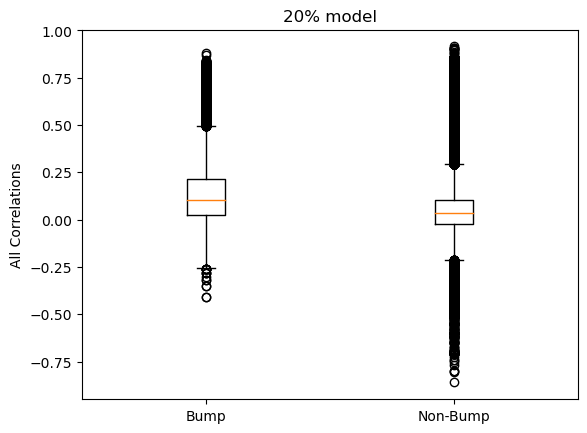

In [679]:
plt.boxplot([flatten_pair_correlations1, flatten_pair_correlations2])
plt.title('20% model')
plt.ylabel('All Correlations')
plt.xticks(np.arange(x_space)+1, ['Bump', 'Non-Bump'], fontsize=10)
plt.show()

In [712]:
stats.ttest_ind(flatten_pair_correlations1,
                flatten_pair_correlations2,
                trim=0.49, equal_var=False)

Ttest_indResult(statistic=54.578908242580674, pvalue=8.700020665328818e-202)

# Signficant Neuron and Pair percentages boxplots

exploring-inner-connection-of-datasets


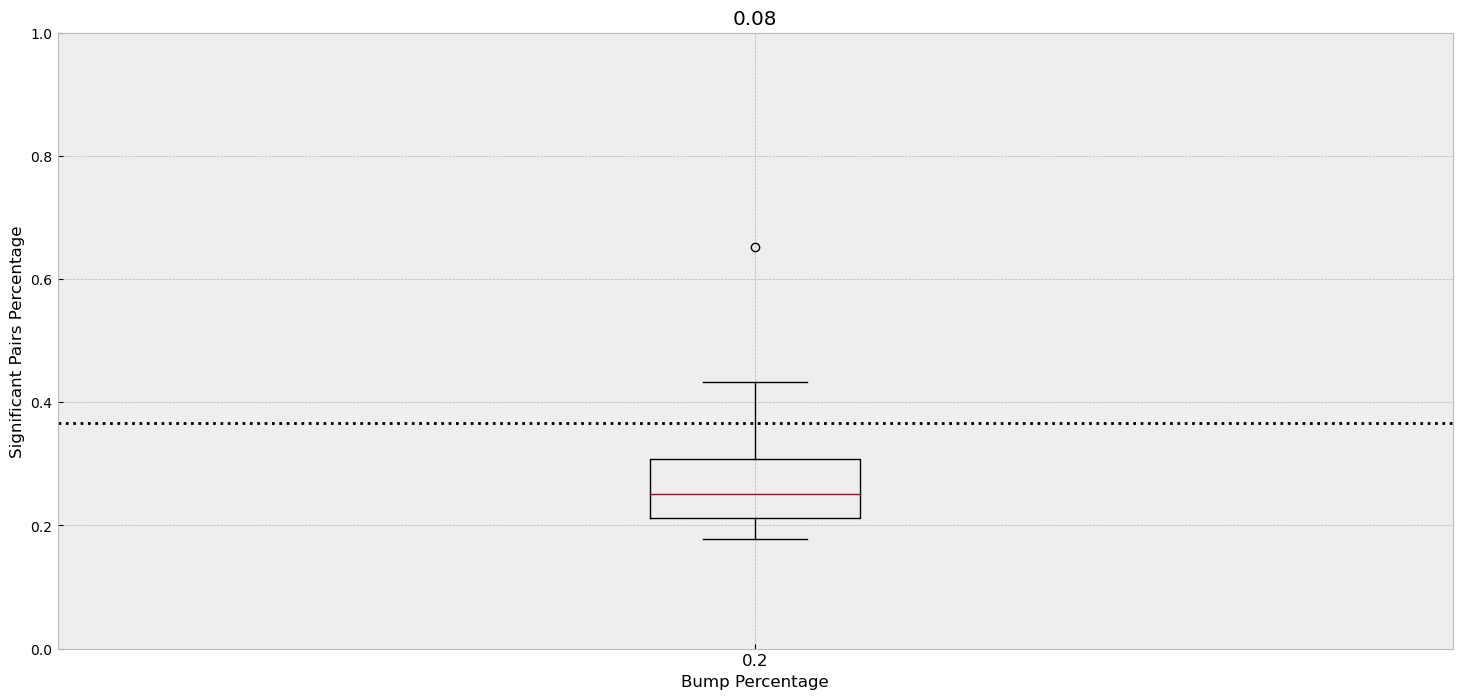

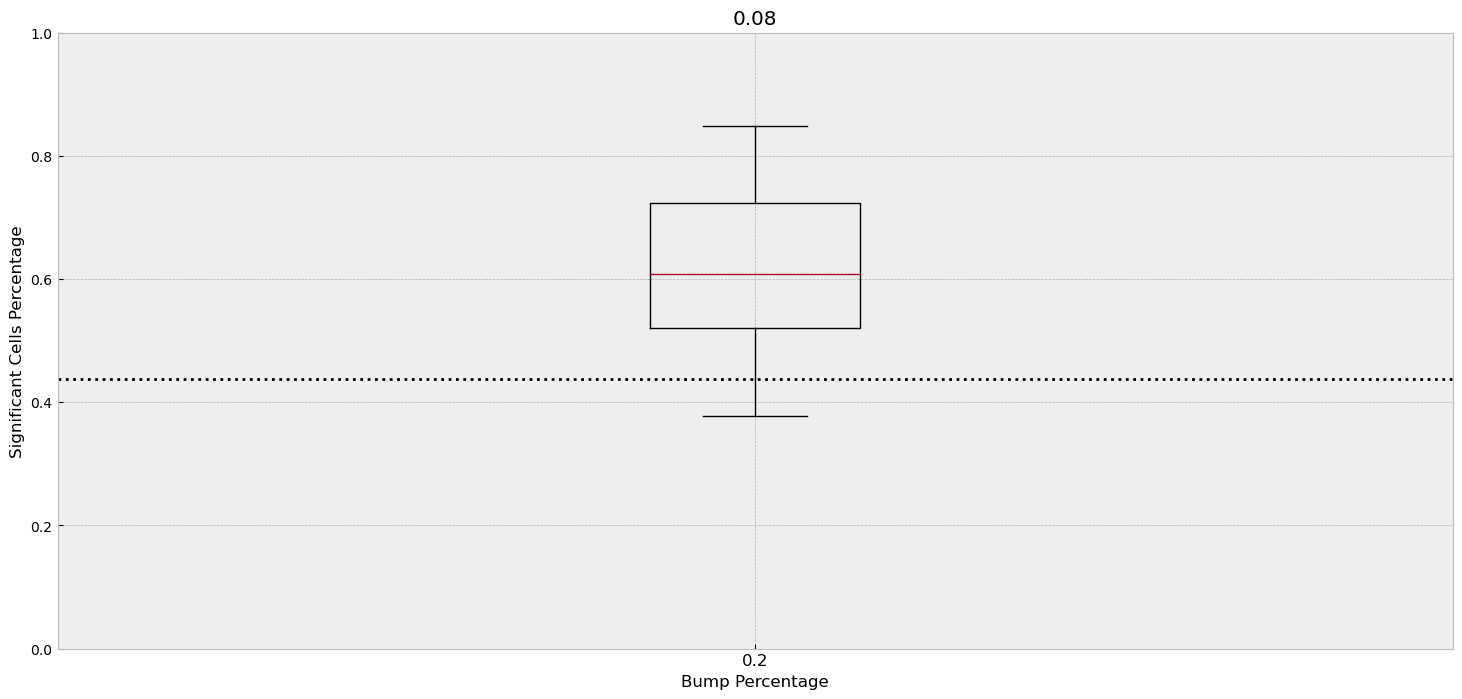

In [105]:
for r, recurrent_noise in enumerate(recurrent_noise_range):
    pair_percentages = defaultdict(list)
    correlations_means = defaultdict(list)
    cell_percentages = defaultdict(list)
    x_axis = []
    for data_folder in data_folder_list:
        print(data_folder)
        for epoch in ['']:
#             print('Epoch: ', epoch)
            for bump_percen in bump_percen_range:
                if bump_percen == 0:
                    N_rec1 = bump_population
                elif bump_percen == 1:
                    N_rec1 = bump_population
                else:
                    N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
                    non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
                model_name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_'
        #         print(model_name)
                for significance_level in significance_level_range:
                    for tau in tau_range:
                        dt = int(tau*dt_percentage[tau])#int(tau/5)
                        for input_sigma in input_sigma_range:
                            for inter_connect_percen in inter_connect_percen_range:
                                for inner_connect_percen in inner_connect_percen_range:
                                    params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'
                                    x_axis.append(bump_percen)
                                    pair_percentages[bump_percen].append(model_significant_pair_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)])
                                    cell_percentages[bump_percen].append(model_significant_neuron_percentages[data_folder+params_values+model_name+'epoch'+str(epoch)])

    plt.figure(figsize=(18,8))
    for b,bump_percent_key in enumerate(pair_percentages.keys()):
            x_space = np.arange(len(pair_percentages[bump_percent_key]))+b*len(pair_percentages[bump_percent_key])
            plt.boxplot(pair_percentages[bump_percent_key], positions=x_space)

    full_space = np.arange(len(pair_percentages[bump_percent_key])*(b+1))
    plt.xticks(full_space, x_axis, fontsize=12)
    plt.ylim([0,1])
    plt.xlabel("Bump Percentage")
    plt.ylabel("Significant Pairs Percentage")
    plt.margins(0.01)
    plt.axhline(y = 15/41, color = 'black', linestyle = 'dotted', label='FEF percentage')

    plt.title(str(recurrent_noise))
    plt.show()

    plt.figure(figsize=(18,8))
    for b,bump_percent_key in enumerate(cell_percentages.keys()):
            x_space = np.arange(len(cell_percentages[bump_percent_key]))+b*len(cell_percentages[bump_percent_key])
            plt.boxplot(cell_percentages[bump_percent_key], positions=x_space)

    full_space = np.arange(len(cell_percentages[bump_percent_key])*(b+1))
    plt.xticks(full_space, x_axis, fontsize=12)
    plt.ylim([0,1])
    plt.xlabel("Bump Percentage")
    plt.ylabel("Significant Cells Percentage")
    plt.margins(0.01)
    plt.title(str(recurrent_noise))

    plt.axhline(y = 21/48, color = 'black', linestyle = 'dotted', label='FEF percentage')
    plt.show()


# Create Pseudo Populations for Model data

In [137]:
model_datasets = defaultdict(dict)
model_datasets_labels = defaultdict(dict)
monkey_session_data = np.load('saved_results/'+'monkey_session_selectivity_trial_data.npy', allow_pickle=True).item()


In [139]:
for epoch in ['']:
    for bump_percen in bump_percen_range:
                    N_rec1 = int(bump_population/bump_percen) # Number of neurons for region1 
                    non_bump_population1 = N_rec1-bump_population # number of non-bump neurons in region1
                    print('Epoch:', epoch)
                    model_name = 'bump'+str(bump_percen)+"_"+str(N_rec1)+'Nrec_'
                    print(model_name)
                    for tau in tau_range:
                        dt = int(tau*dt_percentage[tau])
                        for input_sigma in input_sigma_range:
                            for recurrent_noise in recurrent_noise_range:
                                for inter_connect_percen in inter_connect_percen_range:
                                    for inner_connect_percen in inner_connect_percen_range:
                                        params_values = '/stimulus'+str(outputs)+'/dt'+str(dt)+'/tau'+str(tau)+'/input-noise'+str(input_sigma)+'/rec-noise'+str(recurrent_noise)+'/inter-connect'+str(inter_connect_percen)+'/inner-connect'+str(inner_connect_percen)+'/'
                                        print(params_values)
                                        for region in ['FEF']:
                                            model_data_dict = defaultdict(dict)
                                            combined_session_index = 0
                                            for model_version in model_version_range:
                                                print("Model version: ", model_version)
                                                for session in np.arange(len(monkey_session_data[region])):
                                                    print("Session: ", session)
                                                    # Load datasets
                                                    data = dataset[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    data_labels = np.argmax(dataset_labels[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)],
                                                                                    axis=1)+1
                                                    data_output = dataset_output[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    data_gt = dataset_gt[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
                                                    data_mask = dataset_mask[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]
        #                                             # keep only correct trials
                                                    correct_trials = get_correct_trials(data_gt, data_output, data_mask)
                                                    data = data[correct_trials,:,:]
                                                    data_labels = data_labels[correct_trials]
                                                    print(data.shape)
                                                    print(data_labels.shape)
                                                    combined_session_index+=1
                                                    print("COMBINED SESSION:", combined_session_index)
                                                    significant_neurons_region1 = []
                                                    non_significant_neurons_region1 = []
                                                    significant_neurons_region2 = []
                                                    non_significant_neurons_region2 = []
                                                    
                                                    neuron_pvalues_region1 = defaultdict(list)
                                                    
                                                    #region1
                                                    # create a list for each selective neuron in the session with the p-values of
                                                    # the pairs it takes part in
                                                    if data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch) in version_pairs_region1:
                                                        for j, pair in enumerate(version_pairs_region1[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)]):
                                                            # keep only positively significant pairs 
                                                            if version_correlations_region1[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)][j] > 0:
                                                                for neuron in pair:
                                                                    neuron_pvalues_region1[neuron].append(version_pvalues_region1[data_folder+params_values+model_name+str(model_version)+'_'+region+str(session)+'_epoch'+str(epoch)][j])
#                                                                 print(neuron_pvalues, '\n')
                                                        # keep the neurons with high pvalues as non-significnt 
                                                        for k in neuron_pvalues_region1.keys():
                                                            if np.min(neuron_pvalues_region1[k])>=significance_level:
                                                                non_significant_neurons_region1.append(k)
                                                            else:
                                                                significant_neurons_region1.append(k)

                                                        print('Significant : ', len(significant_neurons_region1))
                                                        print('Non-Significant : ',len(non_significant_neurons_region1))
                                                    else:
                                                        print("Skipped key: ", params_values+model_name+str(model_version)+'_epoch'+str(epoch))

                                                    model_data_dict['significant']['session'+str(combined_session_index)] = data[:,:,significant_neurons_region1]
                                                    model_data_dict['non_significant']['session'+str(combined_session_index)] = data[:,:,non_significant_neurons_region1]

                                                    model_datasets_labels[params_values+model_name]['session'+str(combined_session_index)] = data_labels
                                            model_datasets['epoch'+str(epoch)][params_values+model_name]= model_data_dict.copy()


Epoch: 
bump0.2_180Nrec_
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/
Model version:  0
Session:  0
(295, 58, 180)
(295,)
COMBINED SESSION: 1
Significant :  51
Non-Significant :  9
Session:  1
(292, 58, 180)
(292,)
COMBINED SESSION: 2
Significant :  55
Non-Significant :  8
Session:  2
(244, 58, 180)
(244,)
COMBINED SESSION: 3
Significant :  54
Non-Significant :  3
Session:  3
(215, 58, 180)
(215,)
COMBINED SESSION: 4
Significant :  55
Non-Significant :  3
Session:  4
(291, 58, 180)
(291,)
COMBINED SESSION: 5
Significant :  57
Non-Significant :  5
Session:  5
(294, 58, 180)
(294,)
COMBINED SESSION: 6
Significant :  56
Non-Significant :  1
Session:  6
(332, 58, 180)
(332,)
COMBINED SESSION: 7
Significant :  57
Non-Significant :  5
Session:  7
(340, 58, 180)
(340,)
COMBINED SESSION: 8
Significant :  58
Non-Significant :  5
Session:  8
(407, 58, 180)
(407,)
COMBINED SESSION: 9
Significant :  59
Non-Significant :  5
Session:  9
(135, 58, 180)
(135,)

(155, 58, 180)
(155,)
COMBINED SESSION: 88
Significant :  37
Non-Significant :  6
Session:  10
(231, 58, 180)
(231,)
COMBINED SESSION: 89
Significant :  43
Non-Significant :  10
Session:  11
(213, 58, 180)
(213,)
COMBINED SESSION: 90
Significant :  45
Non-Significant :  6
Session:  12
(140, 58, 180)
(140,)
COMBINED SESSION: 91
Significant :  28
Non-Significant :  13
Session:  13
(161, 58, 180)
(161,)
COMBINED SESSION: 92
Significant :  39
Non-Significant :  8
Session:  14
(133, 58, 180)
(133,)
COMBINED SESSION: 93
Significant :  49
Non-Significant :  3
Session:  15
(129, 58, 180)
(129,)
COMBINED SESSION: 94
Significant :  35
Non-Significant :  3
Session:  16
(317, 58, 180)
(317,)
COMBINED SESSION: 95
Significant :  60
Non-Significant :  5
Session:  17
(330, 58, 180)
(330,)
COMBINED SESSION: 96
Significant :  60
Non-Significant :  4
Session:  18
(255, 58, 180)
(255,)
COMBINED SESSION: 97
Significant :  50
Non-Significant :  6
Session:  19
(256, 58, 180)
(256,)
COMBINED SESSION: 98
Signi

(314, 58, 180)
(314,)
COMBINED SESSION: 175
Significant :  111
Non-Significant :  1
Session:  19
(307, 58, 180)
(307,)
COMBINED SESSION: 176
Significant :  110
Non-Significant :  1
Session:  20
(226, 58, 180)
(226,)
COMBINED SESSION: 177
Significant :  108
Non-Significant :  1
Session:  21
(225, 58, 180)
(225,)
COMBINED SESSION: 178
Significant :  107
Non-Significant :  3
Session:  22
(365, 58, 180)
(365,)
COMBINED SESSION: 179
Significant :  114
Non-Significant :  1
Session:  23
(383, 58, 180)
(383,)
COMBINED SESSION: 180
Significant :  116
Non-Significant :  0
Session:  24
(307, 58, 180)
(307,)
COMBINED SESSION: 181
Significant :  112
Non-Significant :  2
Session:  25
(310, 58, 180)
(310,)
COMBINED SESSION: 182
Significant :  109
Non-Significant :  4
Model version:  7
Session:  0
(314, 58, 180)
(314,)
COMBINED SESSION: 183
Significant :  96
Non-Significant :  2
Session:  1
(301, 58, 180)
(301,)
COMBINED SESSION: 184
Significant :  92
Non-Significant :  2
Session:  2
(233, 58, 180)
(2

In [143]:
model_pseudo_populations = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

model_pseudo_populations_labels = []
labels = np.arange(1,5)
trials_per_label=100
# set the pseudo pop labels
for label in labels:
        model_pseudo_populations_labels.append(np.ones(trials_per_label)*label)
model_pseudo_populations_labels = np.concatenate(model_pseudo_populations_labels)

for epoch in model_datasets.keys():
    for model_key in model_datasets[epoch].keys():
        for neuron_type in model_datasets[epoch][model_key].keys():            
            for session in model_datasets[epoch][model_key][neuron_type].keys():
                print (model_key, neuron_type, session, model_datasets[epoch][model_key][neuron_type][session].shape)
                for n in np.arange(model_datasets[epoch][model_key][neuron_type][session].shape[-1]):
                    single_neuron_trials = []
                    if np.unique(model_datasets_labels[model_key][session]).size==labels.size:
                        for label in labels:
                            selected_trials = np.random.choice(np.where(model_datasets_labels[model_key][session]==label)[0],
                                                               trials_per_label,
                                                               replace=True)
                            model_neuron_data = model_datasets[epoch][model_key][neuron_type][session][selected_trials,:,n]
                            single_neuron_trials.append(model_neuron_data.reshape(model_neuron_data.shape[0], model_neuron_data.shape[1], 1))

                        model_pseudo_populations[epoch][neuron_type][model_key].append(np.concatenate(single_neuron_trials, axis=0))
                    else:
                        print("Skipped session", session)
            model_pseudo_populations[epoch][neuron_type][model_key] = np.concatenate(model_pseudo_populations[epoch][neuron_type][model_key], axis=2)

/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session1 (295, 58, 51)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session2 (292, 58, 55)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session3 (244, 58, 54)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session4 (215, 58, 55)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session5 (291, 58, 57)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session6 (294, 58, 56)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session7 (332, 58, 57)
/stimulus4/dt50/tau200/input-noise

/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session63 (244, 58, 84)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session64 (240, 58, 85)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session65 (178, 58, 73)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session66 (166, 58, 70)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session67 (133, 58, 65)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session68 (141, 58, 66)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session69 (361, 58, 92)
/stimulus4/dt50/tau200/inpu

/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session126 (241, 58, 95)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session127 (354, 58, 106)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session128 (366, 58, 108)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session129 (309, 58, 97)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session130 (309, 58, 104)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session131 (279, 58, 66)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session132 (297, 58, 67)
/stimulus4/dt50/t

/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session187 (263, 58, 93)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session188 (287, 58, 89)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session189 (341, 58, 89)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session190 (362, 58, 89)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session191 (408, 58, 92)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session192 (143, 58, 82)
Skipped session session192
Skipped session session192
Skipped session session192
Skipped session session192
Skipped session session192
Skipped session session19

Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
Skipped session session203
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session204 (206, 58, 

/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ significant session260 (297, 58, 113)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session1 (295, 58, 9)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session2 (292, 58, 8)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session3 (244, 58, 3)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session4 (215, 58, 3)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session5 (291, 58, 5)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session6 (294, 58, 1)
/stimulus4/dt

/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session88 (155, 58, 6)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session89 (231, 58, 10)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session90 (213, 58, 6)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session91 (140, 58, 13)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session92 (161, 58, 8)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session93 (133, 58, 3)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session94 (129, 58, 3)
/sti

/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session224 (129, 58, 10)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session225 (346, 58, 3)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session226 (320, 58, 4)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session227 (285, 58, 2)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session228 (285, 58, 6)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session229 (198, 58, 5)
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ non_significant session230 (192, 58, 9

In [144]:
balancing_pop={}
for epoch in model_pseudo_populations.keys():
    for n_type in model_pseudo_populations[epoch].keys():
        for model_key in model_pseudo_populations[epoch][n_type].keys():
            print(n_type)
            print(model_key)
            print(model_pseudo_populations[epoch][n_type][model_key].shape)
            non_significant_model_neurons = model_pseudo_populations[epoch][n_type][model_key].shape[-1]
            if n_type == 'non_significant':
                balancing_pop[model_key+n_type+epoch] = non_significant_model_neurons
    #         if n_type == '_all':
            elif 'all' in n_type:
                balancing_pop[model_key+n_type+epoch] = non_significant_model_neurons
            elif 'significant' in n_type:
                balancing_pop[model_key+n_type+epoch] = non_significant_model_neurons

significant
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_
(400, 58, 21422)
non_significant
/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_
(400, 58, 978)


In [145]:
model_pseudo_populations['epoch']['significant'].keys()

dict_keys(['/stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_'])

In [146]:
model_pseudo_populations['epoch'].keys()

dict_keys(['significant', 'non_significant'])

# Decoding Mixed Model

In [6]:
# init decoding matrix
model_decoding_matrices = defaultdict(list)
model_decoding_matrices_lda = defaultdict(list)
model_decoding_matrices_pca = defaultdict(list)

np.random.seed(10)
decoding_step = 2

decoding_matrix_length = 58#data.shape[1]
time_points = [int(100/dt),
               int(400/dt),
               int(1400/dt),
               int(1700/dt),
               int(2700/dt)]#[2, 8, 28, 34, 54]
T_range = np.arange(0, decoding_matrix_length)


In [13]:
# load decoding matrices
with open('saved_results/'+'0.2_model_cross_temporal_decoding-FEF-models-PCA-stiched-delays-1000-balanced-36.pkl', 'rb') as f:
    model_decoding_matrices_lda = pickle.load(f)
time_points = [2, 8, 28, 34, 54]
np.random.seed(100)
decoding_step = 2

In [8]:
time_points

[2, 8, 28, 34, 54]

# Run the cross temporal decoding

Epoch:  epoch
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 0 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 0 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 0 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 0 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 0 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 1 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 1 1
significant /stimulus4/dt50/t

bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 14 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 14 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 14 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 14 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 14 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 15 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 15 1
significant /stimulus4/dt50/tau200/i

significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 26 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 26 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 26 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 27 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 27 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 27 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 27 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/

bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 39 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 39 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 39 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 39 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 39 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 40 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 40 1
significant /stimulus4/dt50/tau200/i

significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 51 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 51 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 51 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 52 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 52 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 52 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 52 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/

bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 64 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 64 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 64 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 64 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 64 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 65 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 65 1
significant /stimulus4/dt50/tau200/i

significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 76 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 76 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 76 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 77 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 77 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 77 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 77 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/

bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 89 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 89 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 89 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 89 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 89 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 90 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 90 1
significant /stimulus4/dt50/tau200/i

significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 101 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 101 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 101 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 102 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 102 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 102 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 102 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-conne

significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 113 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 114 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 114 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 114 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 114 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 114 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 115 0
significant /stimulus4/dt50/t

significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 126 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 126 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 126 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 126 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 127 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 127 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 127 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-conne

significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 138 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 138 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 139 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 139 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 139 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 139 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 139 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/t

bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 151 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 151 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 151 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 151 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 151 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 152 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 152 1
significant /stimulus4/dt50/t

significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 163 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 163 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 163 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 164 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 164 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 164 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 164 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-conne

significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 175 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 176 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 176 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 176 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 176 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 176 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 177 0
significant /stimulus4/dt50/t

significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 188 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 188 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 188 3
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 188 4
bump0.2_180Nrec_significanttau200_rec-noise0.08
(400, 58, 36)
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 189 0
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 189 1
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 189 2
significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-conne

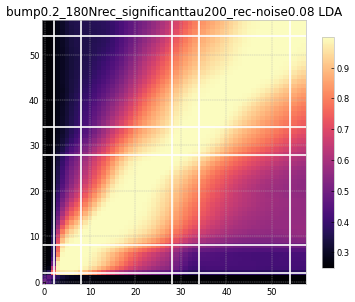

bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 0 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 0 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 0 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 0 3
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 0 4
bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 1 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 1 1
non_sig

non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 12 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 12 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 12 3
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 12 4
bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 13 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 13 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 13 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.

non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 24 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 24 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 24 3
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 24 4
bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 25 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 25 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 25 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.

non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 36 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 36 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 36 3
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 36 4
bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 37 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 37 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 37 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.

non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 48 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 48 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 48 3
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 48 4
bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 49 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 49 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 49 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.

non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 60 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 60 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 60 3
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 60 4
bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 61 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 61 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 61 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.

non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 72 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 72 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 72 3
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 72 4
bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 73 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 73 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 73 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.

non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 84 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 84 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 84 3
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 84 4
bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 85 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 85 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 85 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.

non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 96 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 96 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 96 3
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 96 4
bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 97 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 97 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 97 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.

non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 108 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 108 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 108 3
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 108 4
bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 109 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 109 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 109 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-

non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 120 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 120 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 120 3
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 120 4
bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 121 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 121 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 121 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-

non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 132 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 132 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 132 3
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 132 4
bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 133 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 133 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 133 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-

non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 144 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 144 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 144 3
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 144 4
bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 145 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 145 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 145 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-

non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 156 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 156 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 156 3
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 156 4
bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 157 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 157 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 157 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-

non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 168 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 168 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 168 3
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 168 4
bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 169 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 169 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 169 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-

non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 180 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 180 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 180 3
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 180 4
bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 181 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 181 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 181 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-

non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 192 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 192 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 192 3
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 192 4
bump0.2_180Nrec_non_significanttau200_rec-noise0.08
(400, 58, 36)
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 193 0
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 193 1
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-noise0.08/inter-connect0/inner-connect0.05/bump0.2_180Nrec_ 193 2
non_significant /stimulus4/dt50/tau200/input-noise0.01/rec-

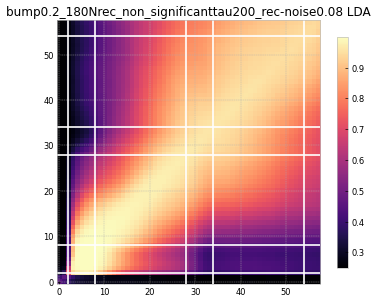

In [309]:
shuffles = 5
balanced_populations= 200

for epoch in model_pseudo_populations.keys():
    print('Epoch: ', epoch)
    for model_pseudo_population in ['significant', 'non_significant']:#model_pseudo_populations[epoch].keys():
        for model_key in model_pseudo_populations[epoch][model_pseudo_population].keys():
            decoding_matrix_length = model_pseudo_populations[epoch][model_pseudo_population][model_key].shape[1]
            rec_noise = model_key.split('/')[-4]
            for balanced_population in np.arange(balanced_populations):
                model_ = model_key.split('/')[-1]+model_pseudo_population+model_key.split('/')[-6]+'_'+rec_noise#+'_'+epoch

                print(model_)
                # balance the populations relative to each case
#                 matched_neurons = np.random.choice(model_pseudo_populations[epoch][model_pseudo_population][model_key].shape[-1],
#                                                    balancing_pop[model_key+'non_significant'+epoch], replace=False)
                matched_neurons = np.random.choice(model_pseudo_populations[epoch][model_pseudo_population][model_key].shape[-1],
#                                                    21, replace=False)
                                                   36)#, replace=False)

                model_data = model_pseudo_populations[epoch][model_pseudo_population][model_key][:,:,matched_neurons]
                print(model_data.shape)
            
#                 # fit the pca on the whole dataset during second part of delays and then use it during decoding
#                 concat_data = np.concatenate([model_data[:,18:28,:],
#                                               model_data[:,44:54,:]], axis=1)
#                 pca = PCA(0.9)
#                 # either fit the mean of the second part of both delays
#                 pca.fit(np.mean(concat_data,axis=1))
#                 # or use all the timebins as features to the PCA
# #                 features = concat_data.shape[-1] # number of neurons
# #                 pca.fit(concat_data.reshape(-1, features))
            
                for shuffle in np.arange(shuffles):
                    print(model_pseudo_population, model_key, balanced_population, shuffle)

                    # cross temporal decoding
                    model_decoding_matrix_lda = np.zeros((int(decoding_matrix_length), int(decoding_matrix_length)))
                    split_dataset = split_train_test(model_data, model_pseudo_populations_labels)

                    for ii, i in enumerate(T_range):
                        train_set = np.mean(split_dataset['train'][:,i:i+decoding_step,:], axis=1)
                        for jj, j in enumerate(T_range):
                            test_set = np.mean(split_dataset['test'][:,j:j+decoding_step,:], axis=1)
                            
                            model_decoding_matrix_lda[ii,jj] = compute_performance_LDA_with_PCAcomponents(train_set, split_dataset['train_labels'],
                                                              test_set, split_dataset['test_labels']) 
#                             model_decoding_matrix_lda[ii,jj] = compute_performance_LDA_with_PCAprefit(train_set, split_dataset['train_labels'],
#                                                               test_set, split_dataset['test_labels'], pca) 
                    # collect decoding matrices for all regions and datasets
                    model_decoding_matrices_lda[model_].append(model_decoding_matrix_lda)
            # plot decoding results
            title = model_
            plot_cross_temporal_decoding(np.mean(model_decoding_matrices_lda[model_], axis=0), title+' LDA',
                                         xylines=time_points,
                                         min_val=0.25, max_val=np.max(np.mean(model_decoding_matrices_lda[model_], axis=0)),
                                         cmap_name='magma')


In [79]:
len(model_decoding_matrices_lda['bump0.2_180Nrec_significanttau200_rec-noise0.08'])

1000

In [150]:
np.max(np.mean(model_decoding_matrices_lda['bump0.2_180Nrec_significanttau200_rec-noise0.08'], axis=0))

0.9996917293233081

In [151]:
np.max(np.mean(model_decoding_matrices_lda['bump0.2_180Nrec_non_significanttau200_rec-noise0.08'], axis=0))

0.9996842105263156

In [330]:
model_decoding_matrices_lda.keys()

dict_keys(['bump0.2_180Nrec_significanttau200_rec-noise0.08', 'bump0.2_180Nrec_non_significanttau200_rec-noise0.08'])

#  Plot the decoding results on custom color range

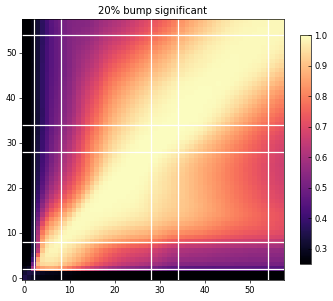

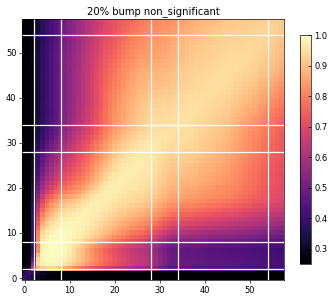

In [190]:
plt.style.use('default')
model_map = {'20% bump ': 'bump0.2_180Nrec_'}

for model_ in ['20% bump ']:
    for model_pseudo_population in model_pseudo_populations['epoch'].keys():
        title = model_+model_pseudo_population

        plot_cross_temporal_decoding(np.mean(model_decoding_matrices_lda[model_map[model_]+model_pseudo_population+'tau200_rec-noise0.08'], axis=0),
                                     title,
                                     xylines=time_points,
                                     min_val=0.25, max_val=1,
                                     cmap_name='magma',
#                                      save=True,
#                                      size=(12,12))
                                     size=(6,6))

In [310]:
# with open('saved_results/'+'0.2_model_cross_temporal_decoding-FEF-models-PCA-stiched-delays-1000-balanced-36.pkl', 'wb') as f:
#     pickle.dump(model_decoding_matrices_lda, f)

# Model data stability

In [15]:
plt.style.use('default')
from analysis_utils import get_code_stability, get_code_stability_off_diagonal, get_information_quantity

In [16]:
model_code_stabilities = defaultdict(list)
model_information_quantity = defaultdict(list)
model_information_quantity2 = defaultdict(list)
model_stability_generalization = defaultdict(list)
model_rectangular_accuracy = defaultdict(list)
for key in model_decoding_matrices_lda.keys():
    print(key)
    for matrix in model_decoding_matrices_lda[key][:]:
        # delay1 code stability
        model_code_stabilities[key+'_delay1_full'].append(get_code_stability(matrix[8:28,8:28]))
        model_code_stabilities[key+'_delay1'].append(get_code_stability(matrix[18:28,18:28]))
        model_information_quantity[key+'_delay1'].append(get_information_quantity(matrix[18:28, 18:28]))

        # delay2 code stability
        model_code_stabilities[key+'_delay2_full'].append(get_code_stability(matrix[34:54,34:54]))
        model_code_stabilities[key+'_delay2'].append(get_code_stability(matrix[44:54,44:54]))
        model_information_quantity[key+'_delay2'].append(get_information_quantity(matrix[44:54, 44:54]))
        
        model_information_quantity[key+'_all'].append(get_information_quantity(matrix[np.ix_(np.concatenate([np.arange(18,28), np.arange(44,54)]),
                                                                                             np.concatenate([np.arange(18,28), np.arange(44,54)]))]))

        # get information quantity and code stability of bottom right part of the cross temporal decoding plot
        # (Trained in D1 and tested in D2)
        # Later will divide these with the respective metrics in D1. (Trained in D1 and tested in D1)
        model_information_quantity2[key].append(get_information_quantity(matrix[18:28, 44:54]))
        model_stability_generalization[key].append(get_code_stability(matrix[18:28, 44:54]))
        
        # whole code stability
        model_code_stabilities[key+'_all_diagonal'].append(get_code_stability(matrix[8:54,8:54]))
        model_code_stabilities[key+'_all_off-diagonal'].append(get_code_stability_off_diagonal(matrix[8:54,8:54]))
        
        
        # get information quantity of first part of delay1
        # get the rectangular of first part of delay1 till the end of the trial for testing and training
        model_information_quantity[key+'_delay1_part1'].append(get_information_quantity(matrix[np.ix_(np.arange(8,18), np.arange(8,18))]))
        model_rectangular_accuracy[key+'_delay1_part1_upper_rect'].append(matrix[np.ix_(np.arange(18,58), np.arange(8,18))])
        upper_trip = np.tril(matrix[np.ix_(np.arange(8,18), np.arange(8,18))], k=-1)
        model_rectangular_accuracy[key+'_delay1_part1_lower_rect'].append(matrix[np.ix_(np.arange(8,18), np.arange(18,58))])
        lower_trip = np.triu(matrix[np.ix_(np.arange(8,18), np.arange(8,18))], k=1)
        model_rectangular_accuracy[key+'_delay1_tri_upper'].append(upper_trip[np.where(upper_trip)])
        model_rectangular_accuracy[key+'_delay1_tri_lower'].append(lower_trip[np.where(lower_trip)])
        
        model_rectangular_accuracy[key+'_delay1_part1'].append([np.mean(matrix[np.ix_(np.arange(18,58), np.arange(8,18))]),
                                                                np.mean(matrix[np.ix_(np.arange(8,18), np.arange(18,58))])])#,
#                                                                         np.mean(upper_trip[np.where(upper_trip)]),
#                                                                         np.mean(lower_trip[np.where(lower_trip)])])
        
        # get full diagonal
        model_information_quantity[key+'_full_diagonal'].append(get_information_quantity(matrix[np.ix_(np.arange(2,58), np.arange(2,58))]))

bump0.2_180Nrec_significanttau200_rec-noise0.08
bump0.2_180Nrec_non_significanttau200_rec-noise0.08


# Save Stability Figures

In [17]:
plt.style.use('default')

plt.style.use('bmh')

<ipython-input-566-1d3a4446682b>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


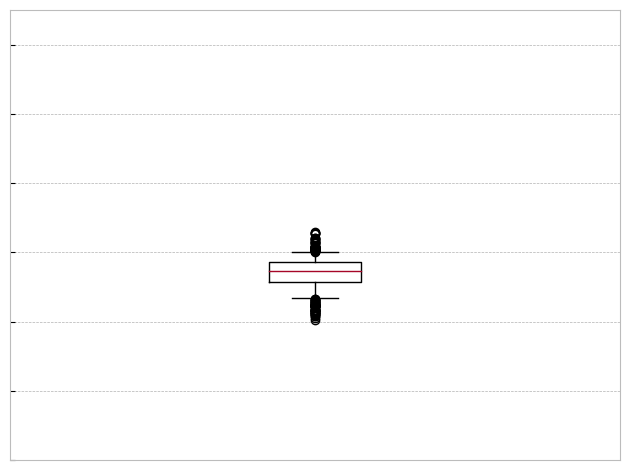

In [566]:
ranges={}
for region in [ '20% bump ']:
    x_space=0
#     for key in ['significant','non_significant']:#model_information_quantity.keys():
#             x_space+=1
    plt.boxplot(np.array(model_information_quantity[model_map[region]+'non_significant'+'tau200_rec-noise0.08_full_diagonal'])/\
                np.array(model_information_quantity[model_map[region]+'significant'+'tau200_rec-noise0.08_full_diagonal']),
                whis=[5, 95], positions=[x_space]);

    plt.xticks(np.arange(x_space)+1, ['Significant', 'Non-Significant'], fontsize=10)
#     plt.ylabel('Full Information Quantity Non-Significant/Significant')
#     plt.title(region)

#     plt.xticks(np.arange(x_space)+1, [])
    plt.ylim([0.7, 1.35])
    plt.yticks(np.arange(0.7,1.35,0.1),[])

    ax = plt.axes()
    ax.set_facecolor("white")
    plt.tight_layout()

#     plt.savefig('eps_images-new/'+region+'_D2-D1-info-quantity-boxplot.pdf',format='pdf')
#     plt.savefig('eps_images-new/'+region+'_D2-D1-code-stability-boxplot-averaged.pdf',format='pdf')
#     plt.savefig('eps_images-new/'+region+'_full-diagonal-boxplot-averaged.pdf',format='pdf')
    plt.savefig('eps_images-new/'+region+'_full-diagonal-non-significant-divided-by-significant.pdf',format='pdf')


    plt.show()

In [19]:
print("Full Information Quantity ")
full_information = np.array(model_information_quantity['bump0.2_180Nrec_non_significanttau200_rec-noise0.08_full_diagonal'])/\
                    np.array(model_information_quantity['bump0.2_180Nrec_significanttau200_rec-noise0.08_full_diagonal'])
print('20% non-sign/sign:', stats.stats.ttest_ind(full_information, np.ones_like(full_information),
                                                 trim=0.49), '\n')

Full Information Quantity 
20% non-sign/sign: Ttest_indResult(statistic=-25.726038749057768, pvalue=1.2070740433692446e-25) 



bump0.2_180Nrec_significanttau200_rec-noise0.08_delay1_part1
bump0.2_180Nrec_non_significanttau200_rec-noise0.08_delay1_part1


<ipython-input-568-3937f271e418>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


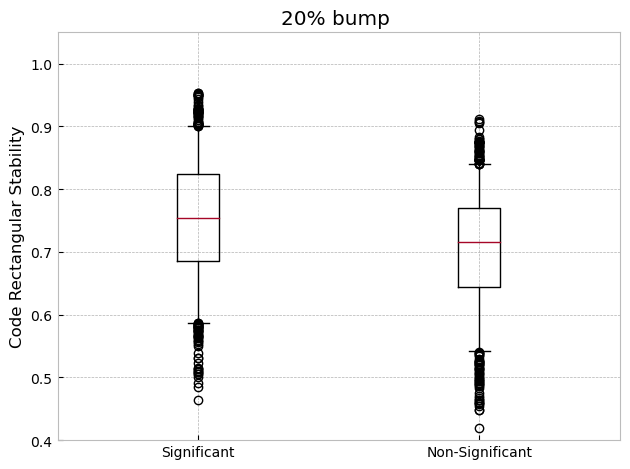

In [568]:
ranges={}
for region in [ '20% bump ']:
    x_space=0
    for key in ['significant','non_significant']:#model_information_quantity.keys():
            x_space+=1
            print(model_map[region]+key+'tau200_rec-noise0.08_delay1_part1')
            info_comparison =  np.mean(model_rectangular_accuracy[model_map[region]+key+'tau200_rec-noise0.08_delay1_part1'],axis=1)/\
                              np.array(model_information_quantity[model_map[region]+key+'tau200_rec-noise0.08_delay1_part1'])
#             np.mean(model_rectangular_accuracy[region+key+'_delay1_part1'], axis=1)/\
#                               np.array(information_quantity[region+key+'_delay1_part1'])
            plt.boxplot(info_comparison, whis=[5, 95], positions=[x_space]);

    plt.xticks(np.arange(x_space)+1, ['Significant', 'Non-Significant'], fontsize=10)
    plt.ylabel('Code Rectangular Stability')
    plt.title(region)

#     plt.xticks(np.arange(x_space)+1, [])
    plt.ylim([0.4, 1.05])
#     plt.yticks(np.arange(0.5,1.4,0.1),[])

    ax = plt.axes()
    ax.set_facecolor("white")
    plt.tight_layout()

#     plt.savefig('eps_images-new/'+region+'_D2-D1-info-quantity-boxplot.pdf',format='pdf')
#     plt.savefig('eps_images-new/'+region+'_D2-D1-code-stability-boxplot-averaged.pdf',format='pdf')

    plt.show()